In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

# Hide Warnings
pd.options.mode.chained_assignment = None

# Intelligent Data Analysis Project: Income

A polling institute wants to be able to estimate an individual’s income from his/her personal data. To this aim, 30.000 individuals were interviewed concerning the features summarized below. For some of the individuals, not all features are available. Crucially, the income of only 5.000 of the interviewee’s is known.

Your task is to predict the income group of the remaining 25.000 interviewees and to prepare the data such that they can be used for further regression and correlation analyses.

Load the data into Python and preprocess it. Choose adequate data transformations, normalizations etc. and decide on how to deal with missing values (marked with “?”). Consider which kinds of features the preprocessed data shall contain. Once you have preprocessed the data, train a model to predict a person’s income group and apply it to the 25.000 individuals whose income group is unknown. Identify a suitable learning method and implement it in Python. Train and evaluate the model. Provide a short documentation and motivation of each of your steps.

In [40]:
# Import data set and add column names
income = pd.read_csv('data/einkommen.train', sep=",", na_values = " ?", header=None)

# Set Column Names
columns = ["Age", "Employment Type", "Weighting Factor", "Education Level", "Schooling/Training Period", "Marital Status", "Employment Area", "Partnership", "Ethnicity", "Gender", "Gains", "Losses", "Weekly Working Time", "Country Of Birth", "Income"]
income.columns = columns

# Remove leading/trailing whitespaces from columns that contain strings
string_columms = income.select_dtypes(object).columns
income[string_columms] = income[string_columms].apply(lambda x: x.str.strip())

In [41]:
# Split data set into sets where Income is known or unknwn
income_labeled = income[income['Income'].notnull()]
income_unlabeled = income[income['Income'].isnull()]

## Problem Setting

Type of Learning Problem: Supervised Learning

Model Space:

Loss-Function / Regulariser: 

## Analysis

### General Overview

In [42]:
print("Number of Rows:", income_labeled.shape[0])
print("Number of Columns (incl. Target):", income_labeled.shape[1])

Number of Rows: 5000
Number of Columns (incl. Target): 15


In [43]:
# Look at input values
income_labeled.head()

,Age,Employment Type,Weighting Factor,Education Level,Schooling/Training Period,Marital Status,Employment Area,Partnership,Ethnicity,Gender,Gains,Losses,Weekly Working Time,Country Of Birth,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [44]:
income_labeled.describe()

,Age,Weighting Factor,Schooling/Training Period,Gains,Losses,Weekly Working Time
count,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000
mean,38.600200,1.907684e+05,10.079600,1033.640200,93.696800,40.519000
std,13.594695,1.063596e+05,2.534906,7051.802077,410.801418,12.109193
min,17.000000,1.930200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176958e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.794750e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.416575e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.033222e+06,16.000000,99999.000000,2547.000000,99.000000


### Analysis of Numeric Variables

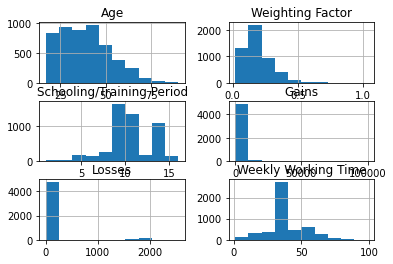

In [45]:
# Check how numeric values are distributed
numeric_distribution = income_labeled.hist()

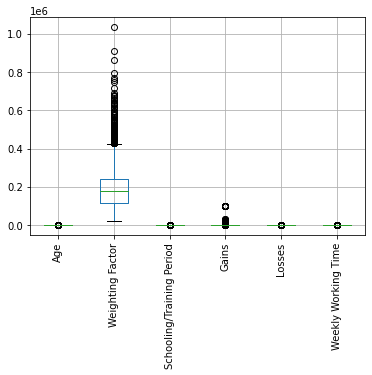

In [46]:
numeric_distribution_boxplot = income_labeled.boxplot()
numeric_distribution_boxplot = numeric_distribution_boxplot.set_xticklabels(numeric_distribution_boxplot.get_xticklabels(),rotation=90)

The boxplots above shows that the numeric variables follow different scales. This indicates that some kind of normalization is needed.

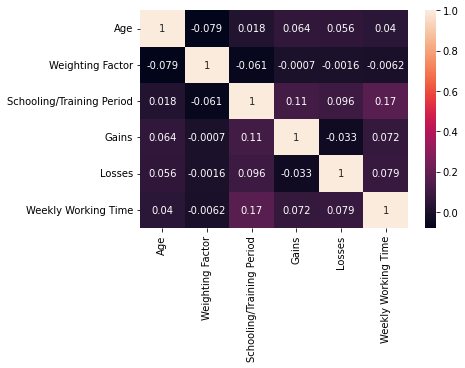

In [47]:
# Correlations between numeric features
correlation_matrix = sns.heatmap(income_labeled.corr(), annot=True)

### Analysis of Categorical Variables

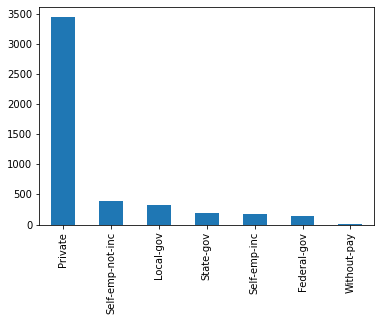

In [48]:
employment_type_distribution = income_labeled['Employment Type'].value_counts().plot(kind='bar')

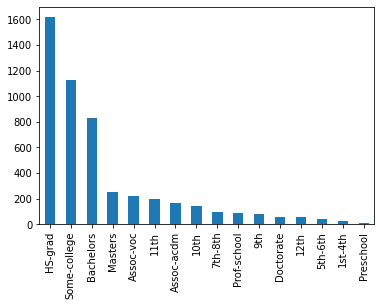

In [49]:
education_distribution = income_labeled['Education Level'].value_counts().plot(kind='bar')

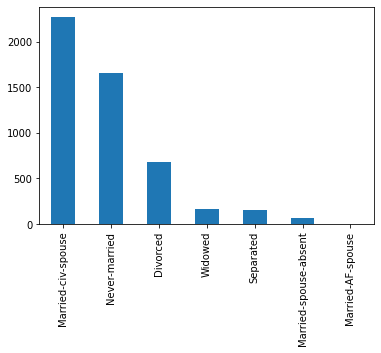

In [50]:
maritial_status_distribution = income_labeled['Marital Status'].value_counts().plot(kind='bar')

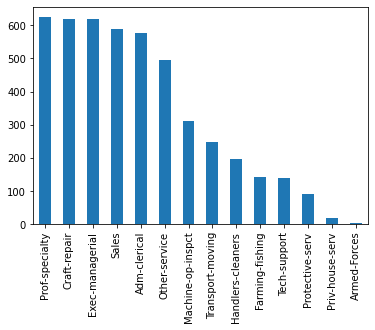

In [51]:
employment_area_distribution = income_labeled['Employment Area'].value_counts().plot(kind='bar')

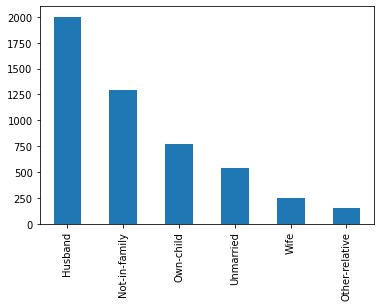

In [52]:
partnership_distributon = income_labeled['Partnership'].value_counts().plot(kind='bar')

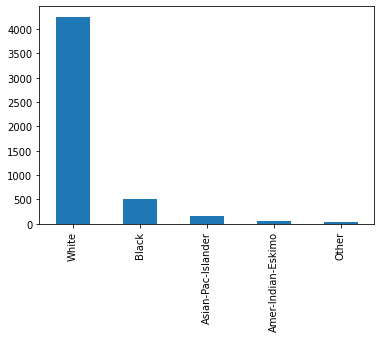

In [53]:
ethnicity_distribution = income_labeled['Ethnicity'].value_counts().plot(kind='bar')

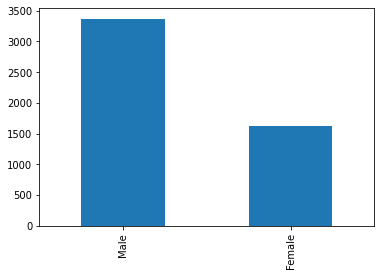

In [54]:
gender_distribution = income_labeled['Gender'].value_counts().plot(kind='bar')

Country Of Birth
United-States    4465
Mexico            104
Canada             28
Philippines        22
Germany            22
Name: Country Of Birth, dtype: int64

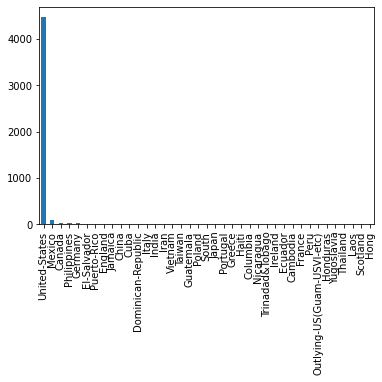

In [55]:
country_distribution = income_labeled['Country Of Birth'].value_counts().plot(kind='bar')

# Top 5 Origin Countries
income_labeled.groupby(['Country Of Birth'])['Country Of Birth'].count().sort_values(ascending=False).head(5)

Nearly all of the interviewed people are from the US (majority class) and all other countries are minority classes. This indicates a low relevance of this feature and bad predictions for people from the minority class countries if we would assume that this feature is a relevant feature for predicting the income.

Income
<=50K    3779
>50K     1221
Name: Income, dtype: int64

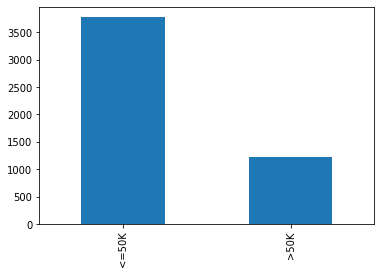

In [56]:
# Check balance between label that has to be predicted
target_distribution = income_labeled['Income'].value_counts().plot(kind='bar', )

income_labeled.groupby(['Income'])['Income'].count()

The target variable is imbalanced because "<= 50K" occurs three times as often as ">50k". Though, the imbalance is only mild as the proportion of the minority class is between 20-40% [1].

### Analysis of Missing Values

In [57]:
print("Number of Rows with NA Values:", income_labeled.isnull().any(axis=1).sum())

print("Fraction of Rows with NA Values", round(income_labeled.isnull().any(axis=1).sum()/income_labeled.shape[0]*100, 2), "%")

income_labeled.isna().sum()

Number of Rows with NA Values: 420
Fraction of Rows with NA Values 8.4 %


Age                            0
Employment Type              331
Weighting Factor               0
Education Level                0
Schooling/Training Period      0
Marital Status                 0
Employment Area              331
Partnership                    0
Ethnicity                      0
Gender                         0
Gains                          0
Losses                         0
Weekly Working Time            0
Country Of Birth              97
Income                         0
dtype: int64

Missing values appear in three columns which are all categorical variables.

## Data Preparation

In [58]:
# Remove irrelevant/unused column
income_labeled = income_labeled.drop('Weighting Factor', axis=1)

In [59]:
# Handling Missing Values
income_labeled = income_labeled.dropna()

In [60]:
from sklearn.preprocessing import OrdinalEncoder

# Ordinal Encoding for Education Level (ordinal)
education_level = ['Preschool','1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', 'Some-college', 'Bachelors', 'Masters', 'Doctorate']
oe_edu = OrdinalEncoder(categories=[education_level])
income_labeled['Education Level'] = oe_edu.fit_transform(income_labeled[['Education Level']])

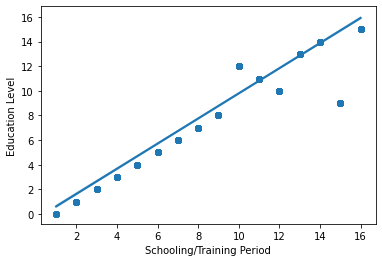

,Education Level,Schooling/Training Period,Income
Education Level,1.000000,0.870818,0.229661
Schooling/Training Period,0.870818,1.000000,0.315673
Income,0.229661,0.315673,1.000000


In [61]:
# Correlation between 'Schooling/Training Period' and 'Education Level'
regression_plot = sns.regplot(x='Schooling/Training Period', y='Education Level', data=income_labeled)
plt.show()


education_correlation = income_labeled.copy()
education_correlation['Income'].replace(['<=50K', '>50K'], [0, 1], inplace=True)

education_correlation[['Education Level', 'Schooling/Training Period', 'Income']].corr()

The feature 'Education Level' (e.g. High School, Bachelor, Master) shows a strong correlation with the feature 'Schooling/Training Period'. Only for higher education levels that allow more flexiblity the linearity between the two features ends. The feature 'Schooling/Training Period' shows a stronger correlation with the target variable 'Income' than the feature 'Education Level'.

In [62]:
# One-Hot Encoding for categorical variables (without order)
one_hot_columns = ['Employment Type', 'Marital Status', 'Employment Area', 'Partnership', 'Ethnicity', 'Gender', 'Country Of Birth']
income_labeled = pd.get_dummies(income_labeled, columns=one_hot_columns)

In [63]:
from sklearn.preprocessing import OneHotEncoder

# Transform Target Variable to Numeric
# income_labeled['Income'].replace(['<=50K', '>50K'], [0, 1], inplace=True)

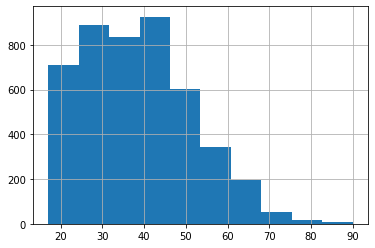

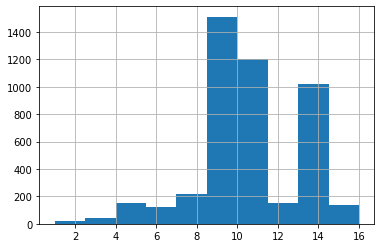

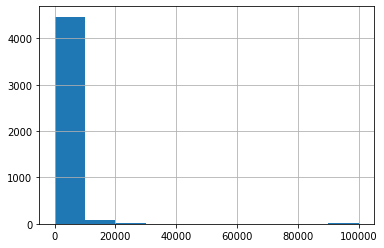

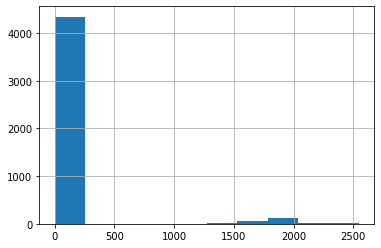

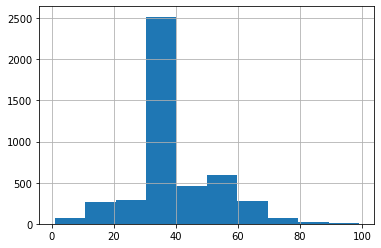

In [64]:
from sklearn.preprocessing import PowerTransformer

# Standardization / Z-Score Normalization

# Age
age_distribution = income_labeled['Age'].hist()
plt.show()

# Schooling/Training Period	
schooling_distribution = income_labeled['Schooling/Training Period'].hist()
plt.show()

# Gains	
schooling_distribution = income_labeled['Gains'].hist()
plt.show()

# Losses
schooling_distribution = income_labeled['Losses'].hist()
plt.show()

# Weekly Working Time
schooling_distribution = income_labeled['Weekly Working Time'].hist()
plt.show()

# --> Binning

In [65]:
from sklearn.model_selection import train_test_split

# Train / Test-Split
income_X_train, income_X_test, income_y_train, income_y_test = train_test_split(income_labeled.drop('Income', axis=1), income_labeled['Income'], test_size=0.25, random_state=42)

In [66]:
print("Data Set after Data Preparation/Preparation")
print("Number of Rows:", income_labeled.shape[0])
print("Number of Columns (incl. Target):", income_labeled.shape[1])

print("\nTrain Data Set")
print("Number of Rows:", income_X_train.shape[0])
print("Number of Columns (excl. Target):", income_X_train.shape[1])

print("\nTest Data Set")
print("Number of Rows:", income_X_test.shape[0])
print("Number of Columns (excl. Target):", income_X_test.shape[1])

Data Set after Data Preparation/Preparation
Number of Rows: 4580
Number of Columns (incl. Target): 87

Train Data Set
Number of Rows: 3435
Number of Columns (excl. Target): 86

Test Data Set
Number of Rows: 1145
Number of Columns (excl. Target): 86


## Methods (& Experiments)

### Linear Classification

In [67]:
from sklearn import svm
from sklearn.metrics import accuracy_score

clf = svm.SVC(random_state=42)
clf.fit(income_X_train, income_y_train)

income_y_pred = clf.predict(income_X_test)

print("Accuracy:", accuracy_score(income_y_test, income_y_pred))

Accuracy: 0.8096069868995633


### Decision Trees

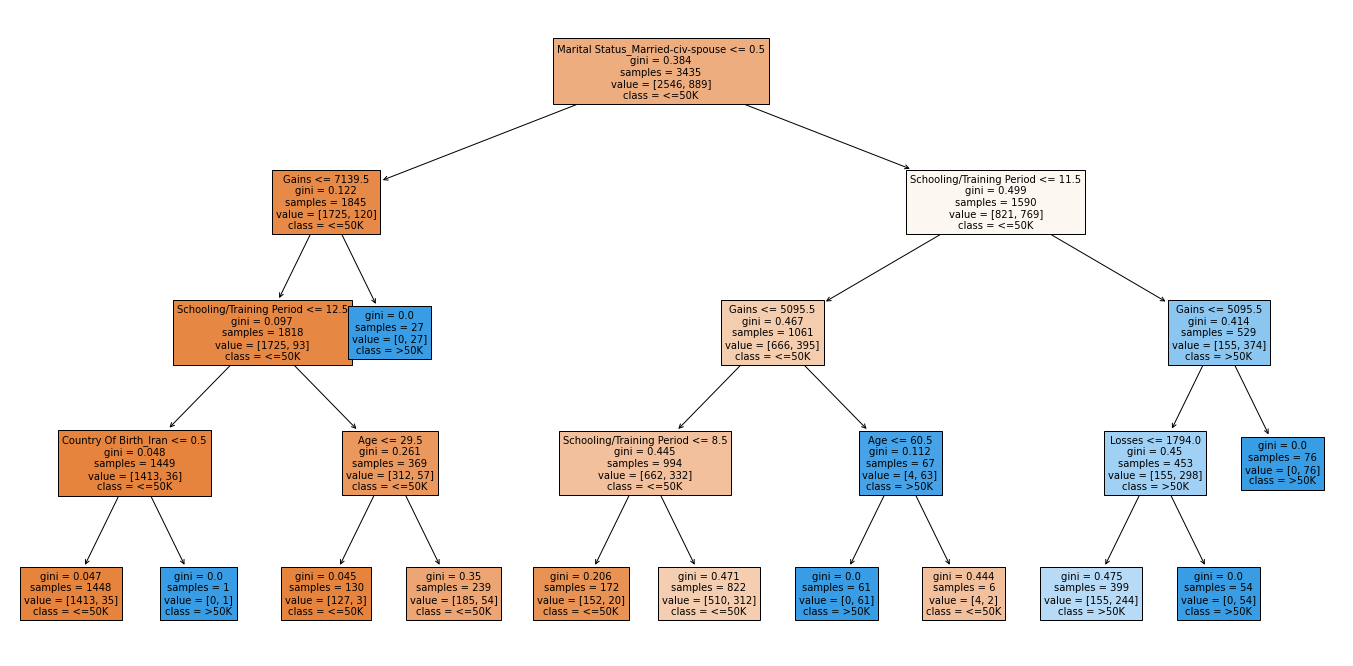

Accuracy: 0.845414847161572


In [68]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=42, max_depth=4)
clf = clf.fit(income_X_train, income_y_train)

plt.figure(figsize=(24,12))
tree.plot_tree(clf, max_depth=4, fontsize=10, feature_names=income_X_train.columns, filled=True, class_names=income_y_train.unique())
plt.show()

income_y_pred = clf.predict(income_X_test)

print("Accuracy:", accuracy_score(income_y_test, income_y_pred))

### Model Evaluation

In [69]:
# ROC/AUC

# Accuracy

## Conclusion

## Extra

In [70]:
# Apply same transformations applied to income_labeled
income_unlabeled = income_unlabeled.drop('Weighting Factor', axis=1)
income_unlabeled = income_unlabeled.drop('Income', axis=1)
income_unlabeled = income_unlabeled.dropna()
income_unlabeled['Education Level'] = oe_edu.fit_transform(income_unlabeled[['Education Level']])
income_unlabeled = pd.get_dummies(income_unlabeled, columns=one_hot_columns)
print(income_unlabeled.shape)

# Filter by columns that were used for training the model
income_unlabeled_X = income_unlabeled[income_X_train.columns.to_list()]
income_unlabeled_y_pred = clf.predict(income_unlabeled_X)

# Merge together
income_unlabled_predicted = income_unlabeled_X
income_unlabled_predicted['Income'] = income_unlabeled_y_pred.tolist()
income_unlabled_predicted['Income'].replace([0, 1], ['<=50K', '>50K'], inplace=True)

(23224, 88)


## References

[1] Imbalanced Data by Google Developers: https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data